In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing
from collections.abc import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

pd.options.mode.chained_assignment = None 

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# label encoder
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

In [2]:
df_cols = [
 'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
 'root_shell','su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 
 'num_outbound_cmds','is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 
 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate','srv_diff_host_rate',
 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate','dst_host_srv_serror_rate',
 'dst_host_rerror_rate','dst_host_srv_rerror_rate', 'outcome'
]
                                                                       
connections = pd.read_csv('network_intrusion_data.csv', names=df_cols)
connections

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


# Data Preprocessing











In [3]:
# drop redundant records, keeping only the 1st occurence of a duplicate record
connections.drop_duplicates(inplace=True)

# delete columns that contain only 0's
connections = connections.loc[:, (connections != 0).any(axis=0)]

In [4]:
connections.shape

(145586, 40)

In [5]:
# any connection that is not 'normal.' labeled z
# labeled z so that is assigned 1 when apply label encoding... fit() returns 
# the data sorted, so: 0 assigned to first sorted label, 1 assigned to next sorted label and so on
connections.loc[connections['outcome'] != 'normal.', 'outcome'] = 'z'
outcomes = encode_text_index(connections,'outcome')

In [ ]:
# only input features with numeric types will be normalized
connections.dtypes

In [7]:
ignore = ['protocol_type', 'service', 'flag', 'outcome']

# normalize numeric input features
for col in range(len(connections.columns)):
    if connections.columns[col] not in ignore:
        encode_numeric_zscore(connections, connections.columns[col])
    
# encode categorical features with one-hot encoding
categorical_features = ['protocol_type', 'service', 'flag']
for col in categorical_features:
    encode_text_dummy(connections, col)   
    
# convert connections dataframe into x y inputs for tensorflow
x,y = to_xy(connections, 'outcome')

print(f"x.shape: {x.shape}")
print(f"y.shape: {y.shape}")

x.shape: (145586, 116)
y.shape: (145586, 2)


In [8]:
# split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Modeling and Evalutating a Fully Connected Neural Network

In [9]:
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(y.shape[1], activation='softmax')) # Output

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')  

# Train the model with train data, validate with test data
model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor], verbose=2, epochs=1000)  

Epoch 1/1000
3413/3413 - 3s - loss: 0.0240 - val_loss: 0.0082 - 3s/epoch - 802us/step
Epoch 2/1000
3413/3413 - 2s - loss: 0.0100 - val_loss: 0.0058 - 2s/epoch - 658us/step
Epoch 3/1000
3413/3413 - 2s - loss: 0.0080 - val_loss: 0.0056 - 2s/epoch - 673us/step
Epoch 4/1000
3413/3413 - 2s - loss: 0.0072 - val_loss: 0.0056 - 2s/epoch - 665us/step
Epoch 4: early stopping


In [10]:
pred = model.predict(x_test)
print(pred[0:5])

[[9.7540521e-08 9.9999988e-01]
 [1.7915622e-07 9.9999976e-01]
 [6.0467920e-07 9.9999940e-01]
 [2.8152294e-07 9.9999976e-01]
 [6.7253211e-08 9.9999988e-01]]


In [11]:
pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
y_true = np.argmax(y_test, axis=1)

In [12]:
precision_score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(precision_score))

recall_score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(recall_score))

f1_score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(f1_score))

accuracy = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(accuracy))

print(metrics.classification_report(y_true, pred))

Precision score: 0.9981910313738469
Recall score: 0.9981866637360222
F1 score: 0.9981860089411956
Accuracy: 0.9981866637360222
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21980
           1       1.00      1.00      1.00     14417

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



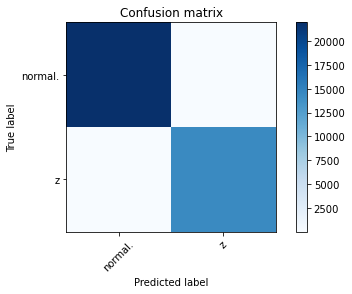

In [13]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure()
plot_confusion_matrix(cm, outcomes)
plt.show()

# Modeling and Evaluating a Convolutional Neural Network

In [15]:
# convert x to data that will fit in a CNN properly
cnn_x = x.reshape((x.shape[0], 1, x.shape[1], 1))
cnn_x.shape

(145586, 1, 116, 1)

In [17]:
# split into train/test
x_train, x_test, y_train, y_test = train_test_split(cnn_x, y, test_size=0.25, random_state=42)

In [18]:
cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 2), strides=(2, 2),
                 activation='relu',
                 input_shape=x_train.shape[1:]))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(x_train.shape[2], kernel_size=(1, 2), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))
    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

# define optimizer and objective, compile cnn
cnn.compile(loss="categorical_crossentropy", optimizer="adam")

# train the cnn model
cnn.fit(x_train, y_train,     
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test))

Epoch 1/10
3413/3413 - 45s - loss: 0.0320 - val_loss: 0.0154 - 45s/epoch - 13ms/step
Epoch 2/10
3413/3413 - 47s - loss: 0.0146 - val_loss: 0.0081 - 47s/epoch - 14ms/step
Epoch 3/10
3413/3413 - 47s - loss: 0.0112 - val_loss: 0.0151 - 47s/epoch - 14ms/step
Epoch 4/10
3413/3413 - 46s - loss: 0.0112 - val_loss: 0.0067 - 46s/epoch - 14ms/step
Epoch 5/10
3413/3413 - 46s - loss: 0.0096 - val_loss: 0.0076 - 46s/epoch - 14ms/step
Epoch 6/10
3413/3413 - 46s - loss: 0.0090 - val_loss: 0.0075 - 46s/epoch - 13ms/step
Epoch 7/10
3413/3413 - 47s - loss: 0.0083 - val_loss: 0.0061 - 47s/epoch - 14ms/step
Epoch 8/10
3413/3413 - 46s - loss: 0.0071 - val_loss: 0.0057 - 46s/epoch - 14ms/step
Epoch 9/10
3413/3413 - 48s - loss: 0.0075 - val_loss: 0.0052 - 48s/epoch - 14ms/step
Epoch 10/10
3413/3413 - 45s - loss: 0.0067 - val_loss: 0.0064 - 45s/epoch - 13ms/step


In [19]:
y_true = np.argmax(y_test, axis=1)
pred=cnn.predict(x_test)
pred = np.argmax(pred, axis=1)

In [20]:
precision_score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(precision_score))

recall_score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(recall_score))

f1_score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(f1_score))

accuracy = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(accuracy))

print(metrics.classification_report(y_true, pred))

Precision score: 0.998461877319429
Recall score: 0.9984614116548067
F1 score: 0.9984611905664952
Accuracy: 0.9984614116548067
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21980
           1       1.00      1.00      1.00     14417

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397



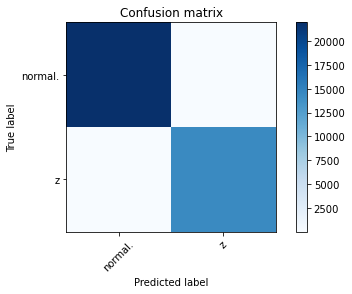

In [21]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure()
plot_confusion_matrix(cm, outcomes)
plt.show()